In [203]:

import numpy as np 
import pandas as pd 



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [204]:
!pwd

/kaggle/working


### **Extracting the train and test data**

In [205]:
# Extractig the training data
import zipfile
from tqdm import tqdm
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip") as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, "./")
        except zipfile.error as e:
            pass

Extracting : 100%|██████████| 25001/25001 [00:08<00:00, 2840.93it/s]


In [206]:
# Extracting the testing data
import zipfile
from tqdm import tqdm
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip") as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, "./")
        except zipfile.error as e:
            pass

Extracting : 100%|██████████| 12501/12501 [00:04<00:00, 2944.98it/s]


In [207]:
import os
os.listdir('./')

['train', 'test1', 'inception_resnet_v2.h5', '__notebook_source__.ipynb']

### **write the datafame with each image path and respective image class (0 or 1)**

In [208]:
# create separate list to store target class (0 or 1) and respective image path
train_filenames=os.listdir('./train')
path=[]
target=[]
for i in train_filenames:
    temp=i.split('.')[0]
    if temp=='cat':
        target.append(0)
    else:
        target.append(1)
    path.append('./train/'+i)

In [209]:
import pandas as pd
data={'Image': path,'Target': target}
df=pd.DataFrame(data)
df.head()


,Image,Target
0,./train/dog.8664.jpg,1
1,./train/cat.9482.jpg,0
2,./train/dog.3008.jpg,1
3,./train/dog.1105.jpg,1
4,./train/dog.939.jpg,1


In [210]:
df.describe()

,Target
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


## **Visualisation**

### **Check all the images are of same size using simple visualisation**

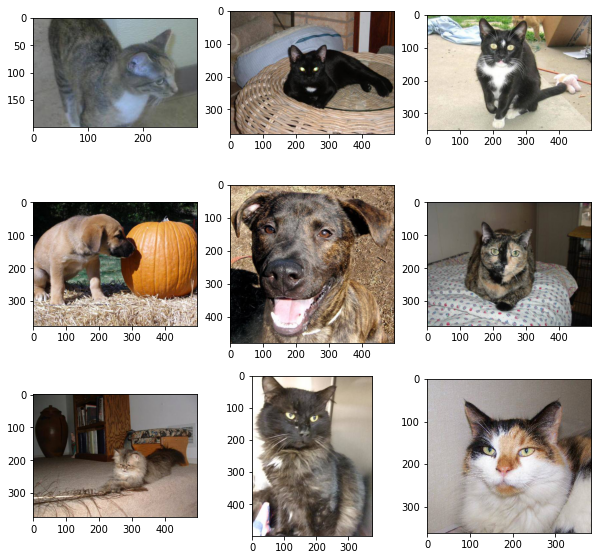

In [211]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
fig = plt.figure(figsize=(10,10))

random.seed(15)
random_list=random.sample(range(0,24999),9)
for i,index in enumerate(random_list):
    plt.subplot(330+1+i)
    file_path=df.loc[index]['Image']
    img=imread(file_path)
    plt.imshow(img)
plt.show()

***Note: Not all the images are of same size***

### **Check the class imbalancing**

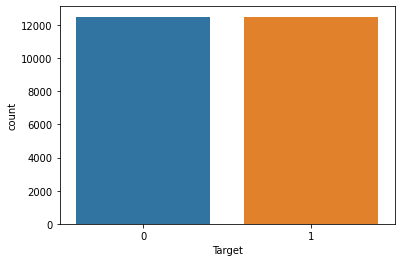

In [212]:
import seaborn as sns
ax=sns.countplot(data=df,x='Target')

In [213]:
f1=target

In [214]:
import sklearn.model_selection as sk
import numpy as np

train_x, val_x, train_y, val_y = sk.train_test_split(path,target,test_size=0.3, random_state=42)
print('Training data:', len(train_x))
print('Training Label:', len(train_y))
print('Validation Data:',len(val_x))
print('Validation Label:', len(val_y))
print('-------------------------------------------')
print('Total Data:', len(train_x)+len(val_x))

Training data: 17500
Training Label: 17500
Validation Data: 7500
Validation Label: 7500
-------------------------------------------
Total Data: 25000


### **Preprocessing of the image**

In [215]:
import cv2
from albumentations import (
    Compose, HorizontalFlip, Blur,
    ToFloat, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, RandomCrop, HueSaturationValue, Normalize, Resize
)

In [216]:
AUGMENTATIONS_TRAIN = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

In [217]:
AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

### **Data Generators using sequence class**

**Our dataset is too large to fit in memory, we have to load the dataset from the hard disk in batches to our memory.**


In [218]:
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

In [219]:
class Cat_Dog_Sequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations, shape):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.shape = shape

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.stack([
            self.augment(image=cv2.resize(cv2.imread(x, 1), self.shape))["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

In [220]:
train_y=np.array(train_y).reshape((len(train_y),1))
val_y=np.array(val_y).reshape((len(val_y),1))
train_gen=Cat_Dog_Sequence(train_x,train_y,16, augmentations=AUGMENTATIONS_TRAIN,shape=(312,312))
val_gen=Cat_Dog_Sequence(val_x,val_y,16, augmentations=AUGMENTATIONS_TEST,shape=(312,312))

In [221]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import EfficientNetB5,InceptionResNetV2
model=InceptionResNetV2(include_top=False, weights='imagenet',input_shape=[312,312,3])

In [222]:
#model.summary()
val_gen

In [223]:
x=model.output

#x=Flatten(name='Flatten')(x)
x=GlobalAveragePooling2D(name='G_avg_pooling')(x)
'''x=Dense(1000,activation=('relu'),name="top_activation_2")(x)
x=Dropout(0.4, name="top_dropout2")(x)
'''
x=Dense(256,activation=('relu'), name="top_activation_3")(x)
x=Dropout(0.3, name="top_dropout3")(x)

x=Dense(1,activation="sigmoid", name="pred")(x)

final_model=Model(model.input,x)

In [224]:
#final_model.summary()

In [225]:
from tensorflow.keras import losses, optimizers, callbacks
file_path='/kaggle/working/inception_resnet_v2.h5'

lr_schedule=callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1, min_lr=0.0001,verbose=1)
checkpoint= callbacks.ModelCheckpoint(file_path, monitor='val_loss',verbose=1,save_best_only=True)
earlystopping= callbacks.EarlyStopping(monitor='val_loss',patience=2,verbose=1)
final_model.compile(optimizer= optimizers.SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

In [226]:
history=final_model.fit(train_gen, epochs=5, callbacks=[lr_schedule,checkpoint,earlystopping],validation_data=val_gen,verbose=1,shuffle=False)

Epoch 1/5
1094/1094 [==============================] - 425s 375ms/step - loss: 0.0777 - accuracy: 0.9748 - val_loss: 0.0417 - val_accuracy: 0.9863

Epoch 00001: val_loss improved from inf to 0.04174, saving model to /kaggle/working/inception_resnet_v2.h5
Epoch 2/5
1094/1094 [==============================] - 406s 371ms/step - loss: 0.0143 - accuracy: 0.9959 - val_loss: 0.0495 - val_accuracy: 0.9856

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00002: val_loss did not improve from 0.04174
Epoch 3/5
1094/1094 [==============================] - 406s 371ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0517 - val_accuracy: 0.9855

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00003: val_loss did not improve from 0.04174
Epoch 00003: early stopping


In [227]:
os.listdir('./')

['train', 'test1', 'inception_resnet_v2.h5', '__notebook_source__.ipynb']

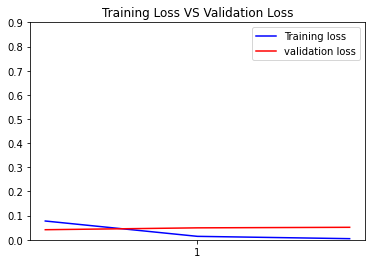

In [230]:
import numpy as np
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(1, 2, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.title('Training Loss VS Validation Loss')
plt.show()

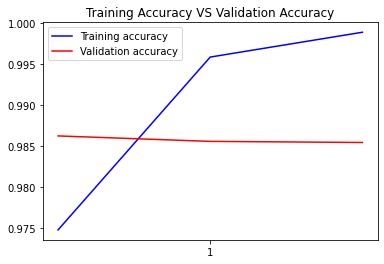

In [231]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(1, 2, 1))
plt.title('Training Accuracy VS Validation Accuracy')
plt.legend()
plt.show()

In [232]:
class Cat_Dog_Test_Sequence(Sequence):
    def __init__(self, x_set,batch_size, augmentations, shape):
        self.x = x_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.shape = shape

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        #batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.stack([
            self.augment(image=cv2.resize(cv2.imread(x, 1), self.shape))["image"] for x in batch_x
        ], axis=0)

In [254]:
# create separate list to store target class (0 or 1) and respective image path
test_filenames=os.listdir('./test1')
test_path=[]
id=[]
for i in test_filenames:
    temp=i.split('.')[0]
    id.append(temp)
    test_path.append('./test1/'+i)

In [235]:
print('No.of.Test Images:',len(test_path))

No.of.Test Images: 12500


In [236]:
test_gen=Cat_Dog_Test_Sequence(test_path, 16, augmentations=AUGMENTATIONS_TEST,shape=(312,312))

In [242]:
output=final_model.predict(test_gen,verbose=1)

782/782 [==============================] - 79s 100ms/step


In [244]:
output.shape

(12500, 1)

In [251]:
output=output.round().astype(np.int32).reshape(output.shape[0])

In [252]:
output.shape

(12500,)

In [255]:
output_csv={'id':id,'label':output}
o=pd.DataFrame(output_csv)

In [257]:
o.to_csv('submission.csv',index=False)

In [258]:
os.listdir('./')

['train',
 'test1',
 'submission.csv',
 'inception_resnet_v2.h5',
 '__notebook_source__.ipynb']